In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [3]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']
df.set_index('date', inplace=True)

In [4]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED'])


In [6]:
# df = drop_future_forecasts(df,5.0)

In [5]:
for feature in df.columns:
    
    df[f'{feature}_shift_1'] = df[feature].shift(1)
    df[f'{feature}_shift_6'] = df[feature].shift(6)
df = df.dropna()

C:\Users\Owner\AppData\Local\Temp\ipykernel_7584\1537105346.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_1'] = df[feature].shift(1)
C:\Users\Owner\AppData\Local\Temp\ipykernel_7584\1537105346.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_6'] = df[feature].shift(6)
C:\Users\Owner\AppData\Local\Temp\ipykernel_7584\1537105346.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [23]:
df.drop(columns=["Price_shift_1", "Price_shift_6"], inplace=True)

In [24]:
import xgboost as xgb
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

y_train_binary = (y_train > 0).astype(int)
y_val_binary = (y_val > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

dtrain = xgb.DMatrix(X_train, label=y_train_binary)
dval = xgb.DMatrix(X_val, label=y_val_binary)
dtest = xgb.DMatrix(X_test, label=y_test_binary)

In [25]:
params = {
    'max_depth': 10,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'seed': 42
}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-logloss:0.39191	val-logloss:0.39651
[100]	train-logloss:0.02732	val-logloss:0.08807
[200]	train-logloss:0.01446	val-logloss:0.07774
[300]	train-logloss:0.00956	val-logloss:0.07528
[400]	train-logloss:0.00685	val-logloss:0.07414
[500]	train-logloss:0.00512	val-logloss:0.07307
[600]	train-logloss:0.00413	val-logloss:0.07246
[614]	train-logloss:0.00399	val-logloss:0.07219


In [26]:
y_pred_proba = model.predict(dtest)
y_pred = (y_pred_proba > 0.5).astype(int)


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(y_test_binary, y_pred)


accuracy = accuracy_score(y_test_binary, y_pred)
precision = precision_score(y_test_binary, y_pred)
recall = recall_score(y_test_binary, y_pred)
f1 = f1_score(y_test_binary, y_pred)
print("Classification Report:")
print(classification_report(y_test_binary, y_pred))

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      2407
           1       0.99      0.98      0.98     16014

    accuracy                           0.97     18421
   macro avg       0.94      0.95      0.94     18421
weighted avg       0.97      0.97      0.97     18421

Accuracy: 0.9735
Precision: 0.9875
Recall: 0.9819
F1 Score: 0.9847


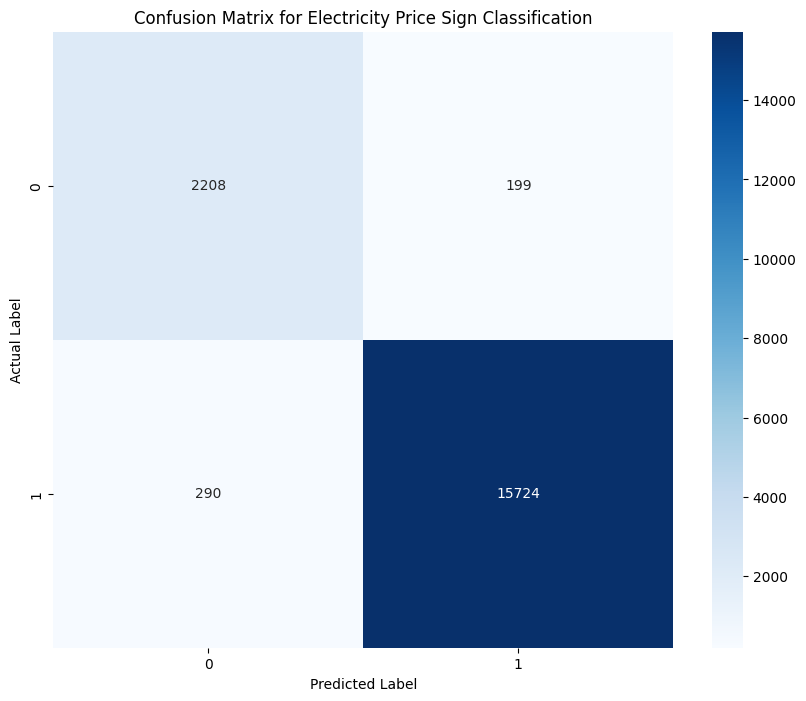

In [29]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Electricity Price Sign Classification')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

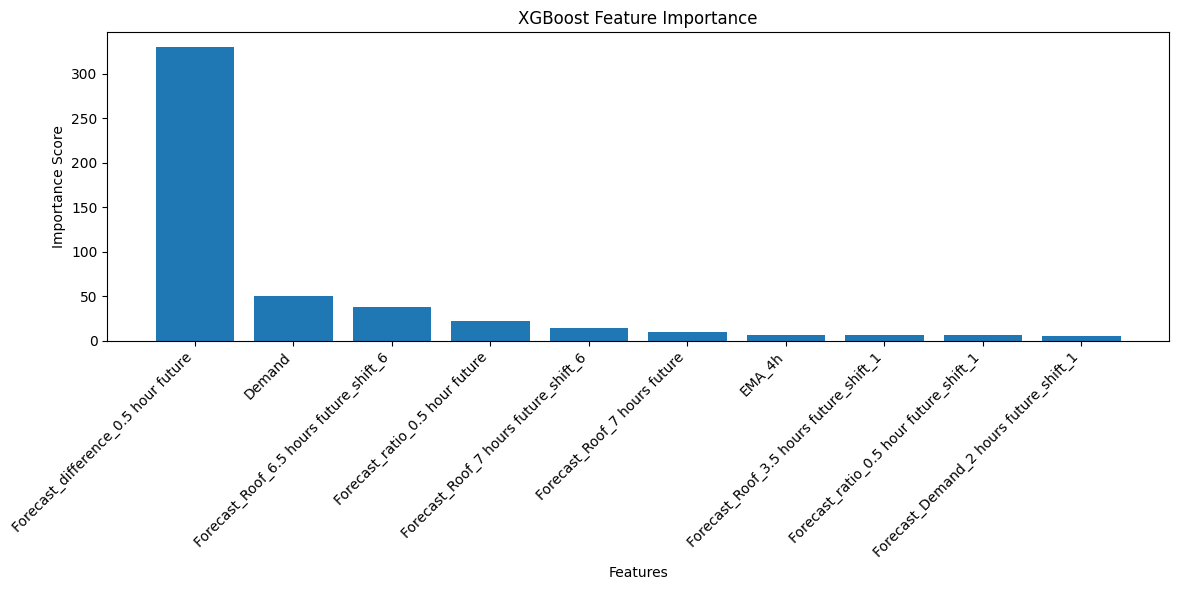

In [30]:
importance = model.get_score(importance_type='gain')
importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
features, scores = zip(*importance[:10])  # Show only top 10 important features

plt.figure(figsize=(12, 6))
plt.bar(features, scores)
plt.title('XGBoost Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Misclassified samples by hour of day:
date
8      31
9     139
10     95
11     61
12     34
13     31
14     46
15     39
16     13
dtype: int64

Misclassified samples by day of week:
date
Friday       127
Monday        51
Saturday      65
Sunday        52
Thursday      73
Tuesday       62
Wednesday     59
dtype: int64

Misclassified samples by month:
date
August     61
July      240
June      188
dtype: int64


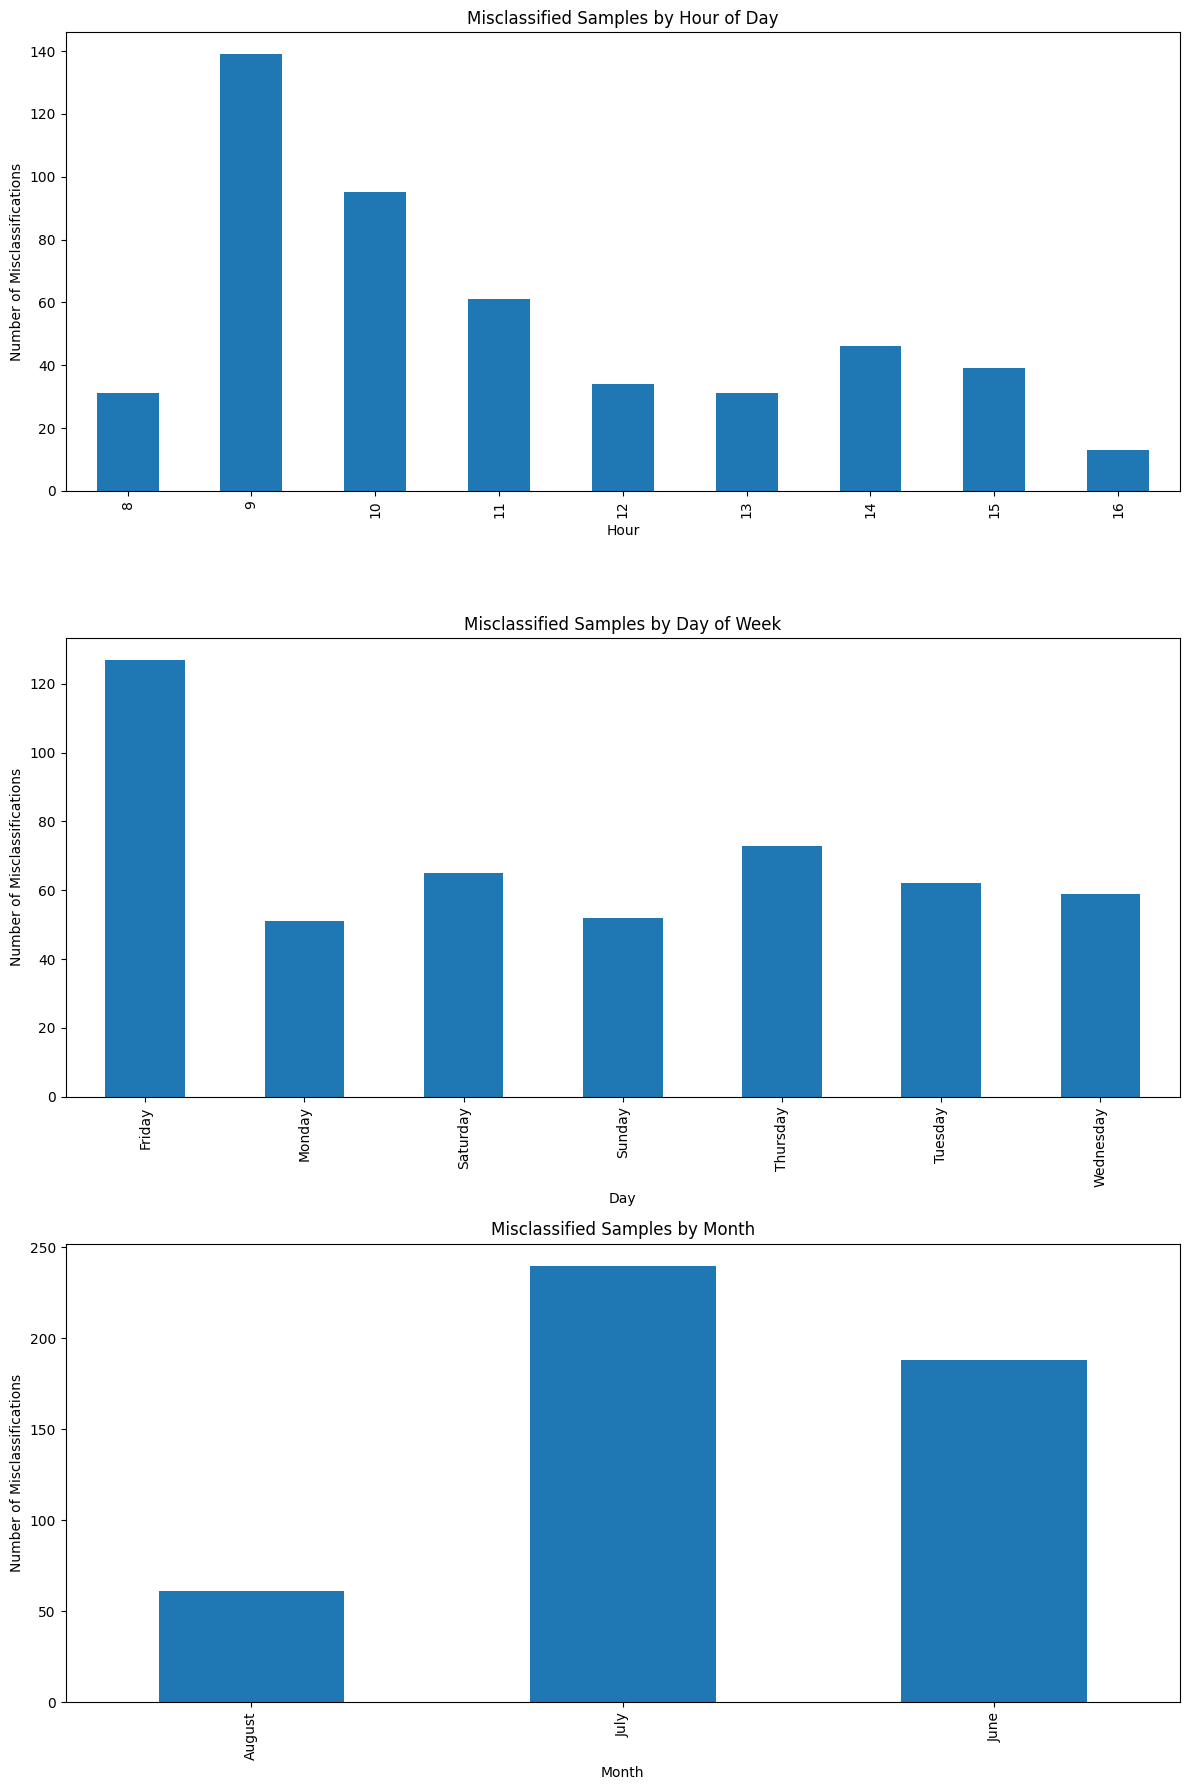


Details of misclassified samples:
                     Actual  Predicted  Misclassified
date                                                 
2024-06-03 09:40:00   38.85          0           True
2024-06-03 09:45:00   24.65          0           True
2024-06-03 09:50:00   27.56          0           True
2024-06-03 09:55:00   48.24          0           True
2024-06-04 09:55:00  -10.50          1           True
...                     ...        ...            ...
2024-08-03 09:00:00   38.42          0           True
2024-08-03 09:05:00   34.75          0           True
2024-08-03 09:10:00   44.75          0           True
2024-08-03 09:15:00   44.75          0           True
2024-08-03 09:20:00   34.75          0           True

[489 rows x 3 columns]

Total number of misclassified samples: 489

Breakdown of misclassification types:
Actual   Predicted
-47.74   1            1
-44.37   1            1
-39.76   1            1
-35.01   1            1
-35.00   1            1
                 

In [31]:
import pandas as pd
import matplotlib.pyplot as plt


results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Misclassified': y_test_binary != y_pred
}, index=X_test.index)

misclassified = results_df[results_df['Misclassified']]


misclassified_by_hour = misclassified.groupby(misclassified.index.hour).size()
misclassified_by_day = misclassified.groupby(misclassified.index.day_name()).size()
misclassified_by_month = misclassified.groupby(misclassified.index.month_name()).size()

# 打印統計結果
print("Misclassified samples by hour of day:")
print(misclassified_by_hour)
print("\nMisclassified samples by day of week:")
print(misclassified_by_day)
print("\nMisclassified samples by month:")
print(misclassified_by_month)

# 視覺化
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))

misclassified_by_hour.plot(kind='bar', ax=ax1)
ax1.set_title('Misclassified Samples by Hour of Day')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of Misclassifications')

misclassified_by_day.plot(kind='bar', ax=ax2)
ax2.set_title('Misclassified Samples by Day of Week')
ax2.set_xlabel('Day')
ax2.set_ylabel('Number of Misclassifications')

misclassified_by_month.plot(kind='bar', ax=ax3)
ax3.set_title('Misclassified Samples by Month')
ax3.set_xlabel('Month')
ax3.set_ylabel('Number of Misclassifications')

plt.tight_layout()
plt.show()

# 打印錯誤分類的樣本詳情
print("\nDetails of misclassified samples:")
print(misclassified)

print(f"\nTotal number of misclassified samples: {len(misclassified)}")

# 如果你想要更詳細的錯誤分析，可以添加以下代碼：
print("\nBreakdown of misclassification types:")
print(misclassified.groupby(['Actual', 'Predicted']).size())

# 如果你的 X_test 包含特徵，你也可以查看這些錯誤樣本的特徵值
if isinstance(X_test, pd.DataFrame):
    print("\nFeature values of misclassified samples:")
    misclassified_features = X_test.loc[misclassified.index]
    print(misclassified_features)